Thermal coupling data. Hourly data not independent. Consider the difference, turn it into one series. The difference will hopefully start off looking like zero. This also removes the different SDs and whatnot. Change Detection on Wikipedia. The mean difference should be zero, but then will move away from zero. Does the difference go from flat, to linearly increasing, to maybe exponential? We're dealing with offline change detection. Make sure to plot the difference. Could also chunk up the data. Change in first couple years? Then check the next.

Could probably use detection algorithm, to see when that change is. 

Once we decide to use all 8 models, should stick to pairwise comparisons. 

Can also focus on top 5% of values and their differences. When do the peaks start to separate?

Hypothesis test of change vs no change. Likelihood ratio something something? We want to reduce some autocorrelation by taking fewer temps e.g. only at 4pm

The differences should look a bit normal.

In [1]:
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import glob

from pathlib import Path

import scipy.stats as stats

from scipy import stats

Okay how do we get a better trend-line as opposed to the up and down? Fewer datapoints? Less than top 5% of temps? And how to "scope in" on where change occurs? graph data for every few years and manually check?

loop over years, then loop over the months within the year. Load in monthly data chunks. Take those observations and pull top 5% of hot scenario. Then take the mean difference of the top 5% (between hot and cold) and the normal full set of observations (just to compare). Output dataframe with year, month, and the mean value, and can graph them both. Include one across BAs.

Should also try random sample from each year. Then think about t-tests for the mean.

In [2]:
def difference_values_top_5(input_BA): # do input_BA as string e.g. 'AEC'
    
    # create list of files to unpack for hot and cold scenario
    list_hot_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', f'{input_BA}_*.csv'))
    list_cold_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD', f'{input_BA}_*.csv'))
    
    # get monthly chunks of data
    list_diff_top_5_means = []
    for file_index in range(len(list_hot_files)):
        
        # read in yearly data as df
        hot_year_df = pd.read_csv(list_hot_files[file_index], index_col = None, header = 0)
        cold_year_df = pd.read_csv(list_cold_files[file_index], index_col = None, header = 0)
        
        # add months column, cold T2 column, and T2 difference column to hot_year_df
        hot_year_df['Month'] = pd.DatetimeIndex(hot_year_df['Time_UTC']).month
        cold_year_df['Month'] = pd.DatetimeIndex(cold_year_df['Time_UTC']).month
        hot_year_df['Cold_T2'] = cold_year_df['T2']
        hot_year_df['T2_Diff'] = hot_year_df['T2'] - hot_year_df['Cold_T2']
        
        # create the monthly dfs for hot and cold
        hot_df1 = hot_year_df[hot_year_df['Month'] == 1]
        hot_df2 = hot_year_df[hot_year_df['Month'] == 2]
        hot_df3 = hot_year_df[hot_year_df['Month'] == 3]
        hot_df4 = hot_year_df[hot_year_df['Month'] == 4]
        hot_df5 = hot_year_df[hot_year_df['Month'] == 5]
        hot_df6 = hot_year_df[hot_year_df['Month'] == 6]
        hot_df7 = hot_year_df[hot_year_df['Month'] == 7]
        hot_df8 = hot_year_df[hot_year_df['Month'] == 8]
        hot_df9 = hot_year_df[hot_year_df['Month'] == 9]
        hot_df10 = hot_year_df[hot_year_df['Month'] == 10]
        hot_df11 = hot_year_df[hot_year_df['Month'] == 11]
        hot_df12 = hot_year_df[hot_year_df['Month'] == 12]
        
        # create a list to iterate over the monthly dfs
        hot_monthly_list = [hot_df1, hot_df2, hot_df3, hot_df4, hot_df5, hot_df6, hot_df7, hot_df8, hot_df9, hot_df10, hot_df11, hot_df12]
        
        for month_df in hot_monthly_list:
            
            # generate the 95% quantile based on the hot T2 values
            month_5_cutoff = month_df['T2'].quantile(0.95)
            
            # find the top 5% hot T2 values for each month
            hot_top_5 = month_df[month_df['T2'] >= month_5_cutoff]
            
            # add the mean of those top 5% values (but from the T2 diff column) to list
            list_diff_top_5_means.append(hot_top_5['T2_Diff'].mean())
            
    # create df from the list of top 5% difference means
    diff_top_5_means_df = pd.DataFrame(list_diff_top_5_means, columns = ['Mean_Difference'])
    
    # create list of years to add to df
    years_list = [range(2020, 2100)]
    years_list_repeated = np.repeat(years_list, 12)
    diff_top_5_means_df['Year'] = years_list_repeated
    
    # create months index to add to df
    months_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    months_list_repeated = months_list * 80
    diff_top_5_means_df['Month'] = months_list_repeated
    
    months_index = pd.date_range(start = '2020-01', end = '2100-01', freq = 'M')
    diff_top_5_means_df['Index'] = months_index
    
    # reorganize columns
    diff_top_5_means_df = diff_top_5_means_df[['Index', 'Year', 'Month', 'Mean_Difference']]
    
        
    return diff_top_5_means_df  # len of list is 960, so a monthly mean value over 80 years of data

In [3]:
def difference_values_general(input_BA): # do input_BA as string e.g. 'AEC'
    
    # create list of files to unpack for hot and cold scenario
    list_hot_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', f'{input_BA}_*.csv'))
    list_cold_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD', f'{input_BA}_*.csv'))
    
    # get monthly chunks of data
    list_diff_means = []
    for file_index in range(len(list_hot_files)):
        
        # read in yearly data as df
        hot_year_df = pd.read_csv(list_hot_files[file_index], index_col = None, header = 0)
        cold_year_df = pd.read_csv(list_cold_files[file_index], index_col = None, header = 0)
        
        # add months column, cold T2 column, and T2 difference column to hot_year_df
        hot_year_df['Month'] = pd.DatetimeIndex(hot_year_df['Time_UTC']).month
        cold_year_df['Month'] = pd.DatetimeIndex(cold_year_df['Time_UTC']).month
        hot_year_df['Cold_T2'] = cold_year_df['T2']
        hot_year_df['T2_Diff'] = hot_year_df['T2'] - hot_year_df['Cold_T2']
        
        # create the monthly dfs for hot and cold
        hot_df1 = hot_year_df[hot_year_df['Month'] == 1]
        hot_df2 = hot_year_df[hot_year_df['Month'] == 2]
        hot_df3 = hot_year_df[hot_year_df['Month'] == 3]
        hot_df4 = hot_year_df[hot_year_df['Month'] == 4]
        hot_df5 = hot_year_df[hot_year_df['Month'] == 5]
        hot_df6 = hot_year_df[hot_year_df['Month'] == 6]
        hot_df7 = hot_year_df[hot_year_df['Month'] == 7]
        hot_df8 = hot_year_df[hot_year_df['Month'] == 8]
        hot_df9 = hot_year_df[hot_year_df['Month'] == 9]
        hot_df10 = hot_year_df[hot_year_df['Month'] == 10]
        hot_df11 = hot_year_df[hot_year_df['Month'] == 11]
        hot_df12 = hot_year_df[hot_year_df['Month'] == 12]
        
        # create a list to iterate over the monthly dfs
        hot_monthly_list = [hot_df1, hot_df2, hot_df3, hot_df4, hot_df5, hot_df6, hot_df7, hot_df8, hot_df9, hot_df10, hot_df11, hot_df12]
        
        for month_df in hot_monthly_list:
            
            # add the mean of the monthly diff values to list
            list_diff_means.append(month_df['T2_Diff'].mean())
            
    # create df from the list of top 5% difference means
    diff_means_df = pd.DataFrame(list_diff_means, columns = ['Mean_Difference'])
    
    # create list of years to add to df
    years_list = [range(2020, 2100)]
    years_list_repeated = np.repeat(years_list, 12)
    diff_means_df['Year'] = years_list_repeated
    
    # create months index to add to df
    months_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    months_list_repeated = months_list * 80
    diff_means_df['Month'] = months_list_repeated
    
    months_index = pd.date_range(start = '2020-01', end = '2100-01', freq = 'M')
    diff_means_df['Index'] = months_index
    
    # reorganize columns
    diff_means_df = diff_means_df[['Index', 'Year', 'Month', 'Mean_Difference']]
        
    return diff_means_df  # len of list is 960, so a monthly mean value over 80 years of data

In [147]:
pd.set_option('display.max_rows', 10)
aeci_diff = difference_values_general('CISO')
aeci_diff

,Index,Year,Month,Mean_Difference
0,2020-01-31,2020,1,-0.126097
1,2020-02-29,2020,2,0.011753
2,2020-03-31,2020,3,0.143575
3,2020-04-30,2020,4,0.314569
4,2020-05-31,2020,5,0.399073
...,...,...,...,...
955,2099-08-31,2099,8,2.073360
956,2099-09-30,2099,9,2.916014
957,2099-10-31,2099,10,2.370215
958,2099-11-30,2099,11,2.301194


In [148]:
aeci_diff_5 = difference_values_top_5('CISO')
aeci_diff_5

,Index,Year,Month,Mean_Difference
0,2020-01-31,2020,1,-0.067436
1,2020-02-29,2020,2,-0.016286
2,2020-03-31,2020,3,0.121316
3,2020-04-30,2020,4,0.299444
4,2020-05-31,2020,5,0.227105
...,...,...,...,...
955,2099-08-31,2099,8,2.073171
956,2099-09-30,2099,9,2.733889
957,2099-10-31,2099,10,2.312105
958,2099-11-30,2099,11,2.342973


Text(0, 0.5, 'T2_Difference (K)')

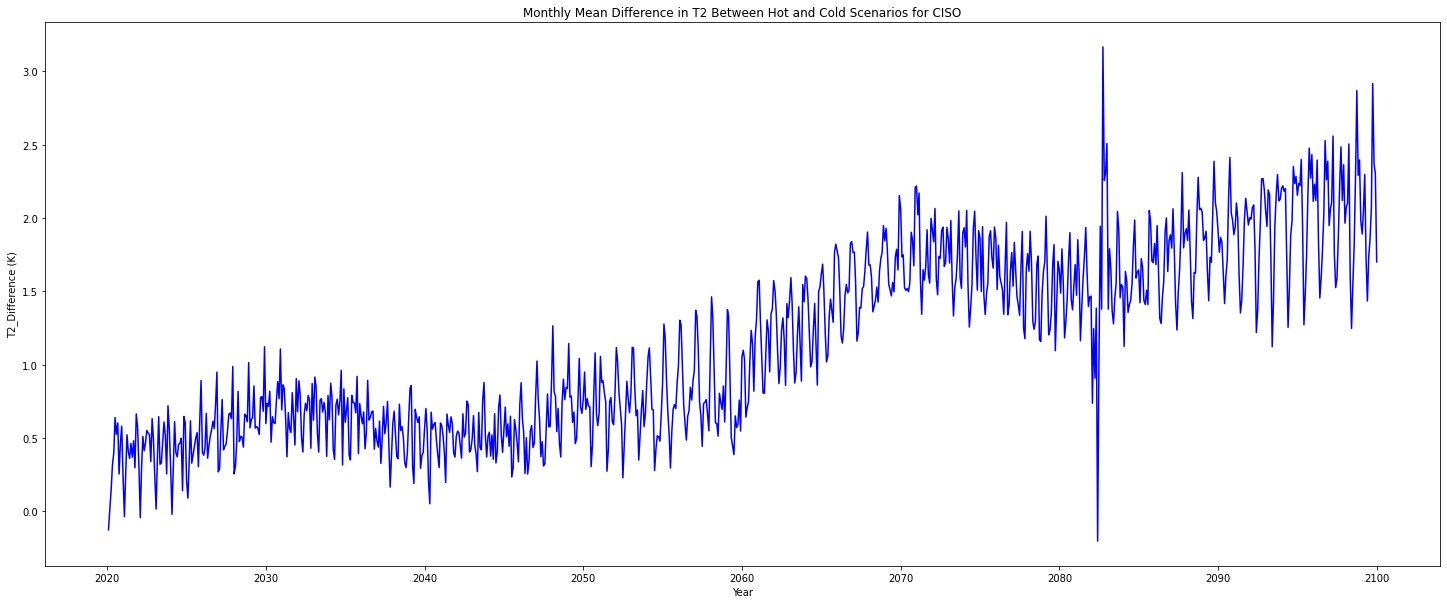

In [152]:
plt.figure(figsize=(25, 10))
plt.plot(aeci_diff['Index'], aeci_diff['Mean_Difference'], color = 'blue')

plt.xlabel('Year')
plt.title('Monthly Mean Difference in T2 Between Hot and Cold Scenarios for CISO')
plt.ylabel('T2_Difference (K)')

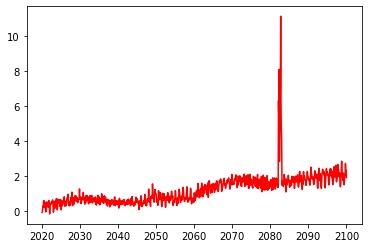

In [150]:
plt.plot(aeci_diff_5['Index'], aeci_diff_5['Mean_Difference'], color = 'red')

Find anomalous year and plot that time series. Try to save images, get plot functions to create more easily. Can also loop over BAs with function to plot all of them.

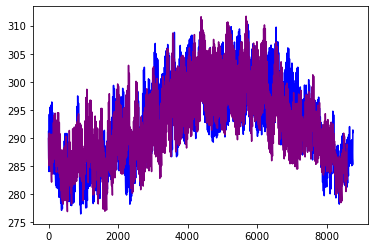

In [126]:
cold_df_2081 = pd.read_csv(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD\CISO_WRF_Hourly_Mean_Meteorology_2081.csv', index_col = None, header = 0)
cold_df_2082 = pd.read_csv(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD\CISO_WRF_Hourly_Mean_Meteorology_2082.csv', index_col = None, header = 0)
cold_df_2083 = pd.read_csv(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD\CISO_WRF_Hourly_Mean_Meteorology_2083.csv', index_col = None, header = 0)

plt.plot(cold_df_2081['T2'], color = 'blue')
plt.plot(cold_df_2082['T2'], color = 'purple')
# plt.plot(cold_df_2083['T2'], color = 'red')

                 Time_UTC      T2       Q2  SWDOWN     GLW  WSPD
0     2081-01-01 00:00:00  292.88  0.00432  112.77  307.96  1.86
1     2081-01-01 01:00:00  289.78  0.00420    0.01  303.07  1.80
2     2081-01-01 02:00:00  288.87  0.00404    0.00  300.15  1.97
3     2081-01-01 03:00:00  288.45  0.00386    0.00  297.90  2.23
4     2081-01-01 04:00:00  288.11  0.00372    0.00  296.86  2.38
...                   ...     ...      ...     ...     ...   ...
8755  2081-12-31 19:00:00  291.62  0.00951  490.67  327.15  1.71
8756  2081-12-31 20:00:00  292.31  0.00950  527.55  325.05  2.10
8757  2081-12-31 21:00:00  292.72  0.00950  500.19  325.55  2.54
8758  2081-12-31 22:00:00  292.75  0.00951  395.92  327.99  2.90
8759  2081-12-31 23:00:00  292.30  0.00957  249.99  329.84  2.85

[8760 rows x 6 columns]


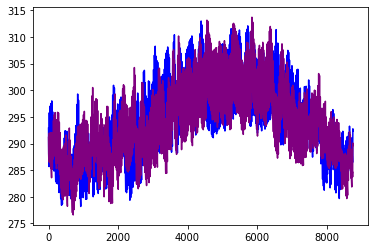

In [125]:
hot_df_2081 = pd.read_csv(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT\CISO_WRF_Hourly_Mean_Meteorology_2081.csv', index_col = None, header = 0)
hot_df_2082 = pd.read_csv(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT\CISO_WRF_Hourly_Mean_Meteorology_2082.csv', index_col = None, header = 0)
hot_df_2083 = pd.read_csv(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT\CISO_WRF_Hourly_Mean_Meteorology_2083.csv', index_col = None, header = 0)
print(hot_df_2081)

plt.plot(hot_df_2081['T2'], color = 'blue')
plt.plot(hot_df_2082['T2'], color = 'purple')
# plt.plot(hot_df_2083['T2'], color = 'red')

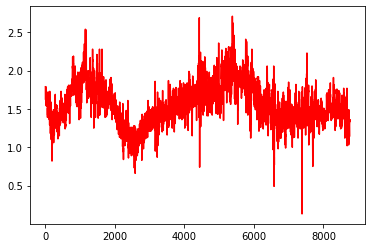

In [111]:
plt.plot(hot_df_2081['T2'] - cold_df_2081['T2'], color = 'red')

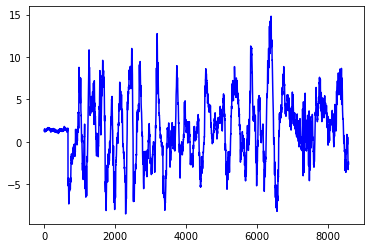

In [112]:
plt.plot(hot_df_2082['T2'] - cold_df_2082['T2'], color = 'blue')

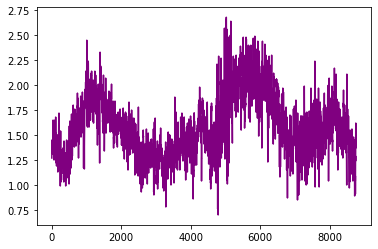

In [113]:
plt.plot(hot_df_2083['T2'] - cold_df_2083['T2'], color = 'purple')

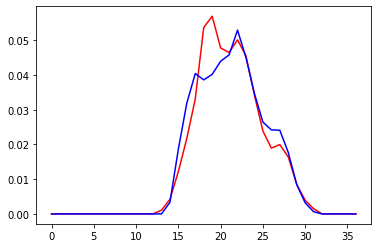

In [114]:
t2_bins = np.arange(250,325,2)
hist_hot_82, bin_edges_hot_82 = np.histogram(hot_df_2082['T2'], bins = t2_bins, density = True)
hist_cold_82, bin_edges_cold_82 = np.histogram(cold_df_2082['T2'], bins = t2_bins, density = True)
hist_hot_81, bin_edges_hot_81 = np.histogram(hot_df_2081['T2'], bins = t2_bins, density = True)
hist_cold_81, bin_edges_cold_81 = np.histogram(cold_df_2081['T2'], bins = t2_bins, density = True)
plt.plot(hist_hot_82, color = 'red')
plt.plot(hist_hot_81, color = 'blue')

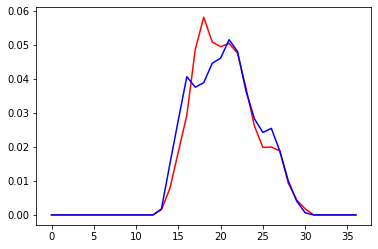

In [115]:
plt.plot(hist_cold_82, color = 'red')
plt.plot(hist_cold_81, color = 'blue')

In [116]:
hot_df_2081['T2_Cold'] = cold_df_2081['T2']
hot_df_2082['T2_Cold'] = cold_df_2083['T2']
hot_df_2083['T2_Cold'] = cold_df_2083['T2']
df_3_years = pd.concat([hot_df_2081, hot_df_2082, hot_df_2083], ignore_index = True)

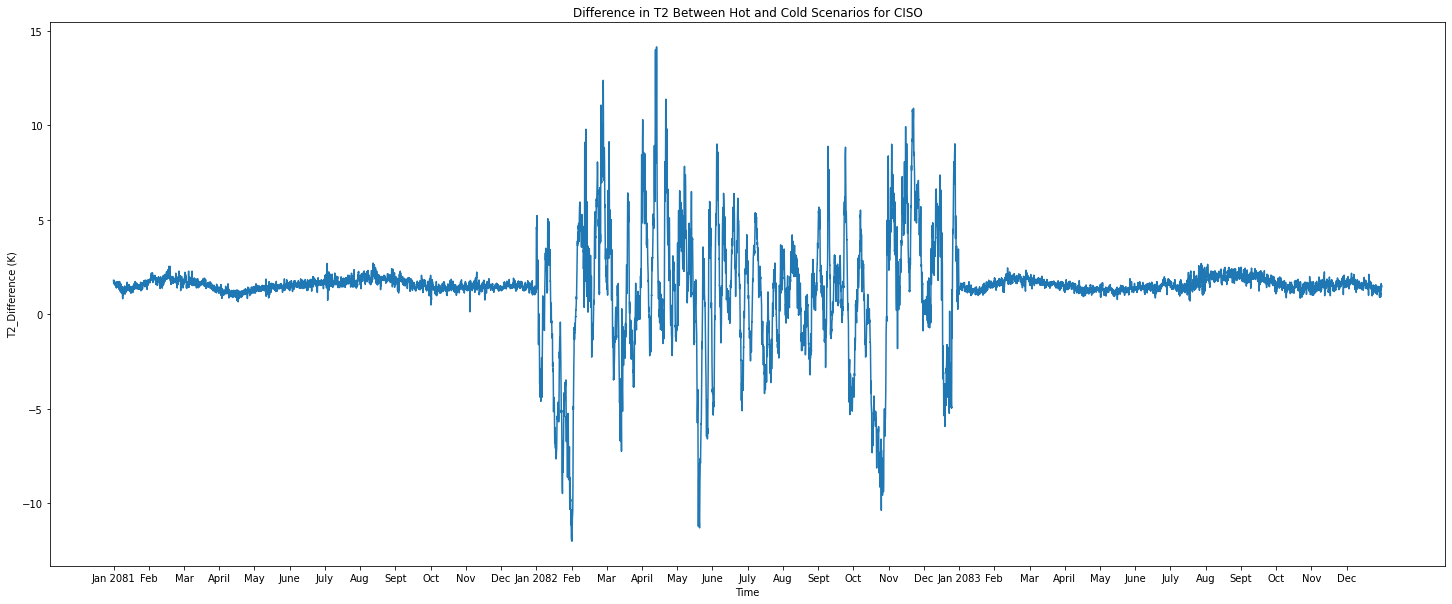

In [146]:
# plot 2081-2083 hot/cold temp differences
plt.figure(figsize=(25, 10))
plt.plot(df_3_years['T2'] - df_3_years['T2_Cold'])

plt.xlabel('Time')
plt.title('Difference in T2 Between Hot and Cold Scenarios for CISO')
plt.ylabel('T2_Difference (K)')
plt.xticks(ticks = range(1, 26280, 730), labels = ['Jan 2081', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
                                                   'Jan 2082', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
                                                   'Jan 2083', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])

In [108]:
list_of_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', "*.csv"))
    
# get a list of unique BA names
BA_names = []
for file_index in range(len(list_of_files)):
    base_name = os.path.splitext(os.path.basename(list_of_files[file_index]))[0]
    split = base_name.split("_")
    if split[0] in BA_names:
        pass
    else:
        BA_names.append(split[0])

# run the two functions, general and top 5%, on each BA, generating a plot for each
for BA in BA_names:
    

['AECI',
 'AEC',
 'AVA',
 'AZPS',
 'BANC',
 'BPAT',
 'CHPD',
 'CISO',
 'CPLE',
 'DOPD',
 'DUK',
 'EPE',
 'ERCO',
 'FMPP',
 'FPC',
 'FPL',
 'GCPD',
 'GVL',
 'HST',
 'IID',
 'IPCO',
 'ISNE',
 'JEA',
 'LDWP',
 'LGEE',
 'MISO',
 'NBSO',
 'NEVP',
 'NSB',
 'NWMT',
 'NYIS',
 'OVEC',
 'PACE',
 'PACW',
 'PGE',
 'PJM',
 'PNM',
 'PSCO',
 'PSEI',
 'SCEG',
 'SCL',
 'SC',
 'SEC',
 'SEPA',
 'SOCO',
 'SPA',
 'SRP',
 'SWPP',
 'TAL',
 'TEC',
 'TEPC',
 'TIDC',
 'TPWR',
 'TVA',
 'WACM',
 'WALC',
 'WAUW']